In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Transfer Learning
Es la tecnica donde un modelo que se desarrollo para una tarea se puede utilizar para otro modelo. De esa forma podemos aprovechar el aprendizajo aprendido y crear un nuevo modelo rapidamente.


## Data de prueba
En este ejemplo usaremos el preentrenado resent 18 cnn, un modelo con mas de un millon de datos y 18 capas de profundidad, capas de clasificar imagenes en 1000 categorias. Supongamos que queremos un modelo que solo neceista 2 clasificaciones: "bees y "ants".

In [2]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(class_names)

['ants', 'bees']


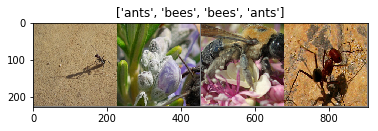

In [3]:

def imshow(inp, title):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [4]:

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


## SCHEDULER
En el fondo se agrega una nueva capa

In [5]:
#### Finetuning the convnet ####
# Cargue un modelo previamente entrenado y restablezca la capa final completamente conectada.

model = models.resnet18(pretrained=True) #Aqui estoy llamando los pesos optimizados entrenados

# Queremos cambiar las últimas capas

num_ftrs = model.fc.in_features

## CREAMOS UNA NUEVA CAPAS
# La entrada es el numero de caracteristicas de la red original que tenia como salida
# El tamaño de cada sample de salida se setea en 2.
# Alternativamente, se puede generalizar a nn.Linear (num_ftrs, len (class_names)).
#model.fc = nn.Linear(num_ftrs, len (class_names)
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe que todos los parámetros se optimizan
optimizer = optim.SGD(model.parameters(), lr=0.001)

### SCHEDULER: Actualizara nuestra tasa de aprendizaje o LR
# StepLR Disminuye la tasa de aprendizaje de cada grupo de parámetros por gamma en cada step_size epochs
# Decaimiento del LR por un factor de 0.1 cada 7 epochs
# La programación de la tasa de aprendizaje (learning rate) debe aplicarse después de la actualización del optimizador
# por ejemplo, debe escribir su código de esta manera:
# for epoch in range(100):
#     train(...)
#     validate(...)
#     scheduler.step()


step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6581 Acc: 0.6107
val Loss: 0.4884 Acc: 0.7778

Epoch 1/24
----------
train Loss: 0.5103 Acc: 0.7336
val Loss: 0.3556 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.4363 Acc: 0.8197
val Loss: 0.2986 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4386 Acc: 0.8033
val Loss: 0.3016 Acc: 0.8824

Epoch 4/24
----------
train Loss: 0.4455 Acc: 0.7787
val Loss: 0.2502 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.3799 Acc: 0.8525
val Loss: 0.2329 Acc: 0.9281

Epoch 6/24
----------
train Loss: 0.4339 Acc: 0.8156
val Loss: 0.2087 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3862 Acc: 0.8443
val Loss: 0.2090 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3972 Acc: 0.8279
val Loss: 0.2182 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3281 Acc: 0.8648
val Loss: 0.2128 Acc: 0.9346

Epoch 10/24
----------
train Loss: 0.3732 Acc: 0.8402
val Loss: 0.2247 Acc: 0.9216

Epoch 11/24
----------
train Loss: 0.3769 Acc: 0.8402
val Loss: 0.2151 Acc: 0.9150

Ep

## Solo entrenar una ultima capa
En este caso hay que tener ojo con los gradientes

In [6]:
#### ConvNet como extractor de funciones fijas ####
# Aquí, necesitamos tener toda la red (la "congelamos" o "freeze") de origen excepto la capa final.
# Necesitamos establecer require_grad == False para congelar los parámetros para que los gradientes no se calculen al revés ()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Los parámetros de los módulos recién construidos tienen require_grad = True por defecto
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe que solo se optimizan los parámetros de la capa final como
# a diferencia de antes.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decaimiento LR por un factor de 0.1 cada 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5645 Acc: 0.7131
val Loss: 0.2904 Acc: 0.8824

Epoch 1/24
----------
train Loss: 0.5352 Acc: 0.7746
val Loss: 0.2917 Acc: 0.8889

Epoch 2/24
----------
train Loss: 0.4709 Acc: 0.8279
val Loss: 0.2278 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.6087 Acc: 0.7746
val Loss: 0.2139 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.6041 Acc: 0.7541
val Loss: 0.1775 Acc: 0.9412

Epoch 5/24
----------
train Loss: 0.4230 Acc: 0.8402
val Loss: 0.1833 Acc: 0.9412

Epoch 6/24
----------
train Loss: 0.3659 Acc: 0.8361
val Loss: 0.2723 Acc: 0.9085

Epoch 7/24
----------
train Loss: 0.4666 Acc: 0.7951
val Loss: 0.1463 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.3259 Acc: 0.8607
val Loss: 0.1553 Acc: 0.9477

Epoch 9/24
----------
train Loss: 0.3578 Acc: 0.8402
val Loss: 0.1577 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.4048 Acc: 0.8320
val Loss: 0.1710 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3115 Acc: 0.8484
val Loss: 0.1493 Acc: 0.9412

Ep